# Preprocessing Techniques
- Tokenization
- Stop Word Removal
- Stemming
- Rare Word Removal

## Tokenization

In [4]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer("I am reading a book now. I love to read books!")
print(tokens)

['i', 'am', 'reading', 'a', 'book', 'now', '.', 'i', 'love', 'to', 'read', 'books', '!']


## Stop Word Removal

In [6]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
print(filtered_tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['reading', 'book', '.', 'love', 'read', 'books', '!']


## Stemming
Convert words to a common format
running, ran, runs will all be converted to **run**

In [7]:
import nltk
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
print(stemmed_tokens)

['read', 'book', '.', 'love', 'read', 'book', '!']


## Rare Word Removal

Remove infrequent words that does not add value

In [10]:
from nltk.probability import FreqDist

freq_dist = FreqDist(stemmed_tokens)
threshold = 2
print(freq_dist)
common_tokens = [token for token in stemmed_tokens if freq_dist[token] >= threshold]
print(common_tokens)

<FreqDist with 5 samples and 7 outcomes>
['read', 'book', 'read', 'book']


# Encoding Text Data

- One-hot encoding: transform words into numerical representations
- Bag-of-Words (BoW): captures word frequency, disregarding order
- TF-IDF: balances uniqueness and importances
- Embedding: converts words into vectors, capture semantic meaning

In Application
- Choose one technique to avoid redudancy

## One-hot encoding with Pytorch

In [12]:
import torch
vocab = ["cat", "dog", "rabbit"]
vocab_size = len(vocab)
one_hot_vectors = torch.eye(vocab_size)
print(one_hot_vectors)
one_hot_dict = {word: one_hot_vectors[i] for i, word in enumerate(vocab)}
print(one_hot_dict)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
{'cat': tensor([1., 0., 0.]), 'dog': tensor([0., 1., 0.]), 'rabbit': tensor([0., 0., 1.])}


## Bag-of-Words
- assign score to a word based on the number of occurrences

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
corpus = ["This is the first document.", "This document is the second document.", "And this is the third one.", "Is this the first document?"]
X = vectorizer.fit_transform(corpus)
print(X.toarray()) # each row match the word frequency for one sentence
print(vectorizer.get_feature_names_out()) #colum names, the word

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


## TF-IDF
- scores the importance of words in a document
- common words have a higher score
- rare ones have a lower score

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus)
print(X.toarray())
print(tfidf_vectorizer.get_feature_names_out())

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


### TF-IDF vs Bag of Word

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

text = ["hello", "hello"]

bow_encoded_text = bow_vectorizer.fit_transform(text)
tfidf_encoded_text = tfidf_vectorizer.fit_transform(text)

print(bow_vectorizer.get_feature_names_out())
print(bow_encoded_text.toarray())

print(tfidf_vectorizer.get_feature_names_out())
print(tfidf_encoded_text.toarray())


['hello']
[[1]
 [1]]
['hello']
[[1.]
 [1.]]


In [14]:
text = ["hello, bro, hello, hello, hello", "hello, bro, ephemeral, ephemeral"]

bow_encoded_text = bow_vectorizer.fit_transform(text)
tfidf_encoded_text = tfidf_vectorizer.fit_transform(text)

print(bow_vectorizer.get_feature_names_out())
print(bow_encoded_text.toarray())

print(tfidf_vectorizer.get_feature_names_out())
print(tfidf_encoded_text.toarray())

['bro' 'ephemeral' 'hello']
[[1 0 4]
 [1 2 1]]
['bro' 'ephemeral' 'hello']
[[0.24253563 0.         0.9701425 ]
 [0.31779954 0.89331232 0.31779954]]


# Building a Text Processing Pipeline

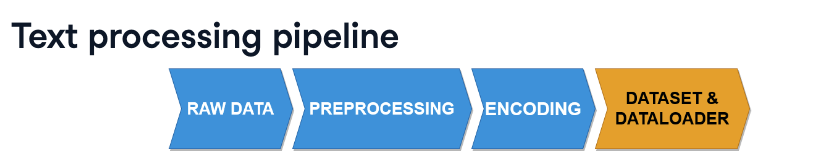

In [74]:
from torch.utils.data import Dataset, DataLoader

The following class intends to create a data container aiming to organize and access our text data efficiently

In [75]:
class TextDataset(Dataset):
    def __init__(self, text):
        self.text = text
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        return self.text[idx]

Side Note on DataLoader:

   - DataLoader serves as the middle man between the data and the model.
   - Depending on the argument value supplied, it will group data into different number of batches
   - It will also randomely suffle the data when feeding into the model if `shuffle = True` is supplied

The following helper function serves to
- extract the raw data
- preprocessing
- encoding

In [14]:
import re

def extract_sentences(data):
    sentences = re.findall(r'[A-Z][^.!?]*[.!?]', data)
    return sentences

In [85]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

from nltk.probability import FreqDist

def preprocess_sentences(sentences, threshold = 1):
    processed_sentences = []
    for sentence in sentences:
        print(sentence)
        sentence = sentence.lower()
        
        tokens = tokenizer(sentence)
        
        tokens = [token for token in tokens if token not in stop_words]
        
        tokens = [stemmer.stem(token) for token in tokens]
        
        freq_dist = FreqDist(tokens)
        tokens = [token for token in tokens if freq_dist[token] > threshold]
        
        processed_sentences.append(" ".join(tokens))
    return processed_sentences

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

def encode_sentences(sentences):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(sentences)
    encoded_sentences = X.toarray()
    return encoded_sentences, vectorizer

After we have encoded our text data, we instantiate the TextDataset and create a DataLoader making it iterable

In [98]:
# Constructing a text processing pipeline

def text_processing_pipeline(text, threshold_for_rare_words_removal = 1):
    tokens = preprocess_sentences(text, threshold_for_rare_words_removal)
    print(tokens)
    encoded_sentences, vectorizer = encode_sentences(tokens)
    print(encoded_sentences)
    dataset = TextDataset(encoded_sentences)
    dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)
    return dataloader, vectorizer

In [99]:
text_data = "This is the first text data. And here is another one."
sentences = extract_sentences(text_data)
print(sentences)

['This is the first text data.', 'And here is another one.']


In [101]:
dataloaders, vectorizer = text_processing_pipeline(sentences, 0)
print(next(iter(dataloaders))[0, :5])

This is the first text data.
And here is another one.
['first text data .', 'anoth one .']
[[0 1 1 0 1]
 [1 0 0 1 0]]
tensor([0, 1, 1, 0, 1])
